## Assign the rat's x,y position to the corresponding hex

Here we do this directly from position/centroids in the nwbfile, but ultimately we will use the position table and HexMazeBlock schema in spyglass

TODO: Save the assigned hex position in a new tbale/schema

In [1]:
import spyglass.data_import as sgi
import spyglass.common as sgc
from spyglass.common import Nwbfile
from pynwb import NWBHDF5IO
import math
import pandas as pd
import numpy as np

# Specify nwbfile name and position series to use for hex assignment
nwb_file_name = "BraveLu20240519_.nwb"
name_of_position_series = 'led_0_series_1'

def euclidean_distance(coord1, coord2):
    """ Calculate Euclidean distance between two coordinates """
    return math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

def assign_to_hex(x_list, y_list, hex_centroids):
    """ 
    Assign each (x, y) coordinate to the nearest hex centroid in hex_centroids.
    
    Make sure the rat's x, y coordinates and the centroids in hex_centroids
    are in the same units (both in pixels or both in cm/meters) !!
    
    Args:
    x_list (list): List of the rat's x coordinates
    y_list (list): List of the rat's y coordinates
    hex_centroids (dict): Dictionary of hex: (x, y) centroid
    
    Returns: 
    List of hexes the same length as x_list and y_list indicating which hex
    this point has been assigned to
    """
    
    # Check that we have the same length x and y
    if len(x_list) != len(y_list):
        raise ValueError("x_list and y_list must have the same length.")
    
    coordinates_list = list(zip(x_list, y_list))
    hex_list = []

    for coord in coordinates_list:
        min_distance = float('inf')
        closest_hex = None
        
        # Loop through all of the hexes to find which one is the closest
        for hex, hex_coords in hex_centroids.items():
            distance_from_hex = euclidean_distance(coord, hex_coords)
            if distance_from_hex < min_distance:
                min_distance = distance_from_hex
                closest_hex = hex
        
        hex_list.append(closest_hex)
    
    return hex_list

nwb_file_path = Nwbfile().get_abs_path(nwb_file_name)
with NWBHDF5IO(nwb_file_path, mode="r+") as io:
    nwbfile = io.read()
    behavior_module = nwbfile.processing["behavior"]

    # Get hex centroids and convert to a dict of hex: (x, y)
    centroids_df = behavior_module.data_interfaces["hex_centroids"].to_dataframe()
    centroids_dict = centroids_df.set_index('hex')[['x', 'y']].apply(tuple, axis=1).to_dict()

    # Get position data (we may have multiple spatial series, so choose the name)
    position = behavior_module.data_interfaces["position"].spatial_series[name_of_position_series]
    position_df = pd.DataFrame(position.data, columns=["x", "y"]) 
    position_df["timestamp"] = position.timestamps
    position_df["hex"] = np.nan

    # Get block data
    block_data = nwbfile.intervals["block"].to_dataframe()
    for block in block_data.itertuples(index=False):
        # Get barrier locations for this block (convert to list of ints)
        barriers = [int(hex) for hex in block.maze_configuration.split(",")]
        
        # Get the centroids of open hexes for this block (remove hexes that are barriers)
        hex_centroids_block = {hex: coords for hex, coords in centroids_dict.items() if hex not in barriers}
        
        # Get position indices for the current block
        block_mask = (position_df["timestamp"] >= block.start_time) & (position_df["timestamp"] <= block.stop_time)

        # Assign each x, y position in this block to a hex 
        position_df.loc[block_mask, "hex"] = assign_to_hex(position_df.loc[block_mask, 'x'], 
                                                           position_df.loc[block_mask, 'y'], 
                                                           hex_centroids_block)

[2025-04-04 17:11:37,386][INFO]: Connecting scrater@lmf-db.cin.ucsf.edu:3306
[2025-04-04 17:11:37,457][INFO]: Connected scrater@lmf-db.cin.ucsf.edu:3306


ValueError: Found 0 matches for BraveLu20240519_.nwb in Nwbfile table: 
*nwb_file_name nwb_file_a
+------------+ +--------+

 (Total: 0)


### Sanity check of assigning the rat's position to a hex

- Create a scatterplot of the rat's position overlayed on the hex grid
- Color the rat's position based on the assigned hex

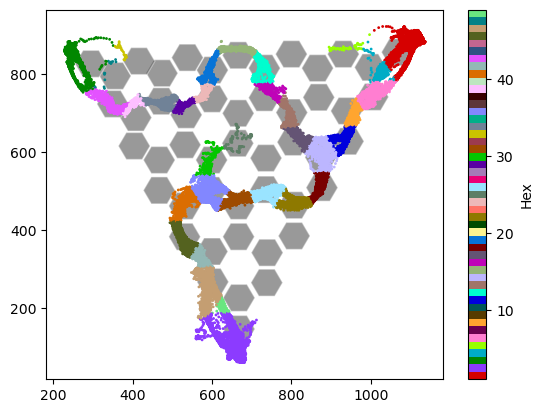

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import math
import colorcet as cc

# Get a colormap of 49 distinct colors so we can color by hex
hex_colormap = ListedColormap(cc.glasbey[:49])

# Plot hexes using the centroids dict from the nwbfile
fig, ax = plt.subplots()
for (x, y) in centroids_dict.values():
    hexagon = patches.RegularPolygon(
        (x, y),
        numVertices=6,
        radius=40, # TODO: replace this with calculated value based on hex spacing
        orientation=math.pi/6,
        edgecolor='white',
        facecolor='black',
        alpha=0.4
    )
    ax.add_patch(hexagon)

# Plot scatter of rat position colored by assigned hex
rat_position = ax.scatter(
    position_df.x,
    position_df.y,
    c=position_df.hex,          
    cmap=hex_colormap,
    s=1
)
cbar = plt.colorbar(rat_position, ax=ax)
cbar.set_label('Hex')
plt.show()

In [ ]:
# Starting hex assignment from spyglass... 
# abandoned bc of checksum issues for now but will come back hehe
import spyglass.data_import as sgi
import spyglass.common as sgc
from spyglass.common import Nwbfile
from hex_maze_behavior import HexMazeConfig, HexMazeBlock
from pynwb import NWBHDF5IO

nwb_file_name = "BraveLu20240519_.nwb"
interval_list_name = "pos 1 valid times"
sgc.Session & {"nwb_file_name": nwb_file_name}

# Get position from schema
raw_position_df = (sgc.RawPosition() 
                   & {"nwb_file_name": nwb_file_name, 
                      "interval_list_name": interval_list_name}
                   ).fetch1_dataframe()
display(raw_position_df)

# Get block info from schema
block = (HexMazeBlock() & {"nwb_file_name": nwb_file_name})
display(block)

# Open nwbfile to get centroids!
nwb_file_path = Nwbfile().get_abs_path(nwb_file_name)
with NWBHDF5IO(nwb_file_path, 'r') as io:
    nwbfile = io.read()
    behavior_module = nwbfile.processing["behavior"]

    # Get hex centroids and convert to a dict of hex: (x, y)
    centroids_df = behavior_module.data_interfaces["hex_centroids"].to_dataframe()
    centroids_dict = centroids_df.set_index('hex')[['x', 'y']].apply(tuple, axis=1).to_dict()

print(centroids_dict)

for epoch in block["epoch"]:
   print(epoch)

   #  # Get block data
   #  block_data = nwbfile.intervals["block"].to_dataframe()
   #  for block in block_data.itertuples(index=False):
   #      # Get barrier locations for this block (convert to list of ints)
   #      barriers = [int(hex) for hex in block.maze_configuration.split(",")]
        
   #      # Get the centroids of open hexes for this block (remove hexes that are barriers)
   #      hex_centroids_block = {hex: coords for hex, coords in centroids_dict.items() if hex not in barriers}
        
   #      # Get position indices for the current block
   #      block_mask = (position_df["timestamp"] >= block.start_time) & (position_df["timestamp"] <= block.stop_time)

   #      # Assign each x, y position in this block to a hex 
   #      position_df.loc[block_mask, "hex"] = assign_to_hex(position_df.loc[block_mask, 'x'], 
   #                                                         position_df.loc[block_mask, 'y'], 
   #                                                         hex_centroids_block)


   #  display(position_df)